В данном ноутбуке отобрал и красиво оформил все гипотезы. Черновик можно посмотреть в sber_test_task_draft.ipynb

In [78]:
# необходимые библиотеки
#pip install catboost seaborn

# 1. Import and read data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
PATH = '../data/online_shoppers_intention.csv'

In [3]:
data = pd.read_csv(PATH)
data.head(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

# 2. Гипотезы и их проверки

**Гипотезы:**
- 1) "PageValue" сильно коррелирует с "Revenue", при значениях "PageValue" равных 0, скорее всего на странице нельзя купить товар, или на ней никто ничего не покупает;
- 2) Чем больше "ProductRelated_Duration", тем больше вероятность конверсии;
- 3) Чем больше "ProductRelated", тем больше вероятность конверсии;
- 4) Чем ближе "SpecialDay" к 0.6 тем больше вероятность конверсии, если не учитывать обычные (при которых "SpecialDay" равен 0).

## 2.1 Проверка первой гипотезы

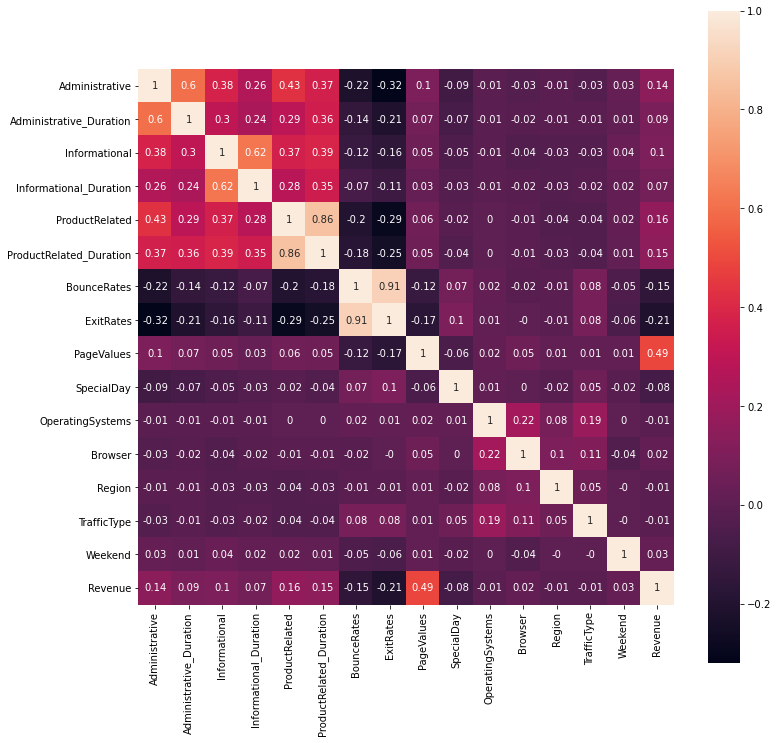

In [4]:
plt.rcParams["figure.figsize"] = (12, 12)

sns.heatmap(
    data=data.corr().round(2),
    square=True,
    annot=True,
);

In [8]:
print('Количество "Revenue" при которых "PageValues" равно 0')
print(data[data.PageValues == 0.0]['Revenue'].value_counts())
print()
print('Количество "Revenue" при которых "PageValues" не равно 0')
print(data[data.PageValues != 0.0]['Revenue'].value_counts())

Количество "Revenue" при которых "PageValues" равно 0
False    9230
True      370
Name: Revenue, dtype: int64

Количество "Revenue" при которых "PageValues" не равно 0
True     1538
False    1192
Name: Revenue, dtype: int64


**Вывод:** Как можно заметить "PageValue" коррелирует с "Revenue", и при значении "PageValue" = 0 очень маленький шанс конверсии

## 2.2 Проверка второй гипотезы

In [21]:
plt.rcParams["figure.figsize"] = (10, 10)

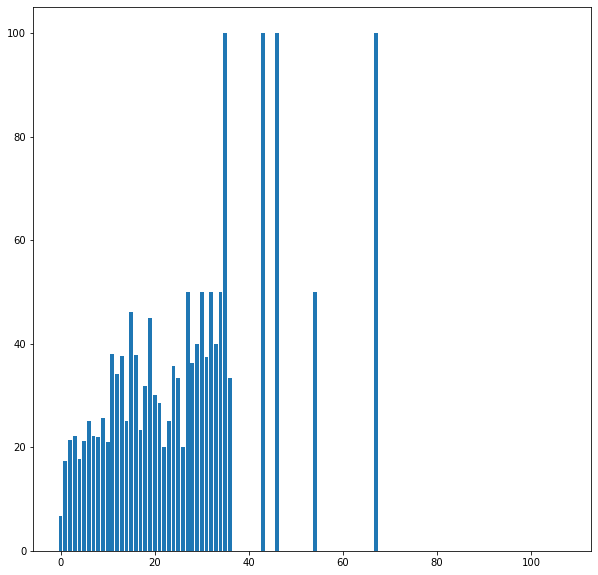

In [38]:
# разбиваем ProductRelated_Duration на отрезки и кодируем числами
bins = np.arange(-1, max(data.ProductRelated_Duration) + 2, 400)
labels = np.arange(len(bins)- 1)
data['ProductRelatedBins'] = pd.cut(data.ProductRelated_Duration, bins=bins, labels=labels)

groupby_PRD = data.groupby('ProductRelatedBins')['Revenue'].agg(lambda x: (x).sum() * 100 / len(x))

x = groupby_PRD.index
y = groupby_PRD.values

plt.bar(x, y);

**Вывод:** Как можно заметить гипотеза подтвердилась.

## 2.3 Проверка третьей гипотезы

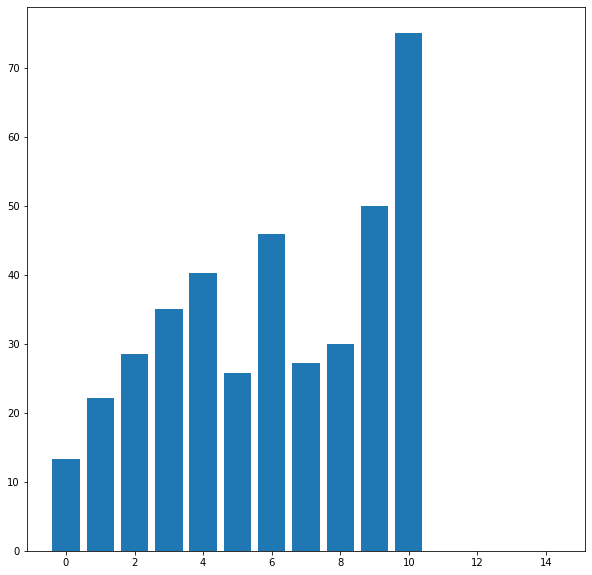

In [40]:
# разбиваем ProductRelated на отрезки и кодируем числами
bins = np.arange(-1, max(data.ProductRelated_Duration) + 2, 50)
labels = np.arange(len(bins)- 1)
data['ProductRelatedBins'] = pd.cut(data.ProductRelated, bins=bins, labels=labels)

groupby_PR = data.groupby('ProductRelatedBins')['Revenue'].agg(lambda x: (x).sum() * 100 / len(x))

x = groupby_PR.index
y = groupby_PR.values
plt.bar(x, y);

**Вывод:** Как можно заметить гипотеза подтвердилась.

## 2.4 Проверка четвёртой гипотезы

<AxesSubplot:xlabel='SpecialDay', ylabel='count'>

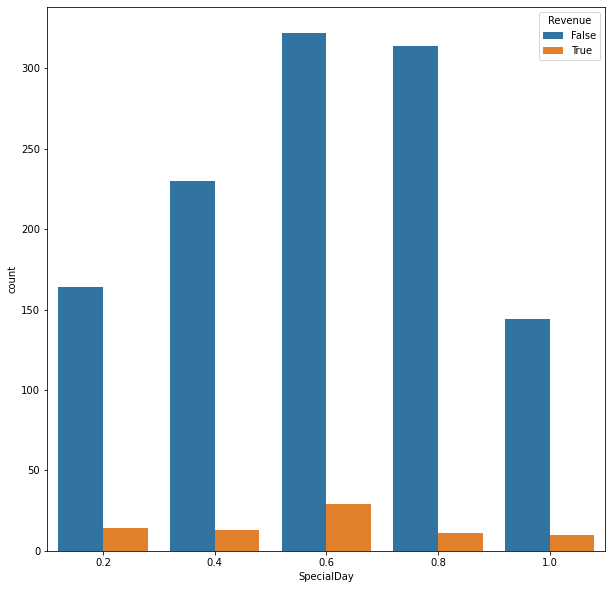

In [41]:
sns.countplot(data=data[data.SpecialDay != 0.0],
              x='SpecialDay',
              hue='Revenue')

In [70]:
data.groupby('SpecialDay')['Revenue'].agg(lambda x: (x).sum() * 100 / len(x)).iloc[1:]

SpecialDay
0.2    7.865169
0.4    5.349794
0.6    8.262108
0.8    3.384615
1.0    6.493506
Name: Revenue, dtype: float64

**Вывод:** Как можно заметить количество конверсий и вероятность конверсий при значении "SpecialDay" = 0.6.

# 3 Обучение модели

In [61]:
data = pd.read_csv(PATH)
cat_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']
X = data.drop('Revenue', axis=1)
y = data.Revenue.values.astype(np.int32)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=24)

## 3.1 Train, test split

In [71]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=24)

In [72]:
clf = CatBoostClassifier(n_estimators=200,
                         depth=4,
                         l2_leaf_reg=0.2,
                         min_child_samples=10,
                         verbose=False,
                         random_state=24,
                         eval_metric='AUC',
                         custom_metric=['Logloss',
                                        'AUC',
                                        'Accuracy'],
                        )

In [73]:
clf.fit(X_train,
        y=y_train,
        cat_features=cat_features,
        use_best_model=True,
        eval_set=(X_val, y_val),
        early_stopping_rounds=40,
        verbose=False,
        plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [74]:
print(clf.get_best_score())

{'learn': {'Accuracy': 0.9117366412213741, 'Logloss': 0.21759946998406873}, 'validation': {'Accuracy': 0.8979007633587787, 'Logloss': 0.23490659451109103, 'AUC': 0.9297212468299751}}


In [75]:
print(
    "accuracy score --", accuracy_score(clf.predict_proba(X_test).argmax(axis=1), y_test),
    "roc auc score --", roc_auc_score(clf.predict(X_test), y_test)
)

accuracy score -- 0.9037837837837838 roc auc score -- 0.8344594594594594


Сохраняем

In [76]:
MODEL_PATH = '../models/main_model'
clf.save_model(MODEL_PATH)

## 3.2 KFold (бонус)

In [67]:
n_splits = 5
clfs = []
acc_scores = []
auc_scores = []
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=24)

for num, (train_index, test_index) in enumerate(kf.split(X=X, y=y)):

    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]

    clf = CatBoostClassifier(
                         max_depth=6,
                         n_estimators=200,
                         verbose=False,
                         random_state=24,
                         eval_metric='AUC',
                         custom_metric=['Logloss',
                                        'AUC',
                                        'Accuracy'],)
    clfs.append(clf)

    clf.fit(X_train,
            y_train,
            cat_features=cat_features,
            verbose=False)

    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_pred, y_val)
    auc = roc_auc_score(y_pred, y_val)
    acc_scores.append(acc)
    auc_scores.append(auc)
    
    print(f"fold {num}: acc: {acc}, auc: {auc}")

assert len(clfs) == n_splits
print(
    "mean accuracy score --", np.mean(acc_scores, dtype="float16"),
    "mean roc auc score --", np.mean(auc_scores, dtype="float16"),
)

fold 0: acc: 0.8969465648854962, auc: 0.816294253106258
fold 1: acc: 0.9017175572519084, auc: 0.8214616425671344
fold 2: acc: 0.9060114503816794, auc: 0.8335469811562619
fold 3: acc: 0.898854961832061, auc: 0.8244716820720892
fold 4: acc: 0.8983778625954199, auc: 0.811799501867995
mean accuracy score -- 0.901 mean roc auc score -- 0.822


In [68]:
pred = np.zeros(shape=(len(X_test), 2))
for n, model in enumerate(clfs):
    pred += model.predict_proba(X_test)

last_pred = pred.argmax(axis=1)
print(
    "accuracy score --", accuracy_score(last_pred, y_test),
    "roc auc score --", roc_auc_score(last_pred, y_test)
)

accuracy score -- 0.9064864864864864 roc auc score -- 0.8440864803356802


Сохраним 5 моделей

In [77]:
for num, model in enumerate(clfs):
    model.save_model(f'../models/clf_{num}')